In [2]:
# 라이브러리 로드
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import joblib

In [3]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 데이터 로드 및 기본 정보 확인
df = pd.read_csv("dataset/winequality-red.csv")
print("데이터 개요:")
print(df.info())
print(df.describe())

데이터 개요:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  15

In [4]:
# 데이터 전처리
df.dropna(inplace=True)

# 독립변수(X): 품질(quality)을 제외한 나머지
X = df.drop('quality', axis=1)

# 종속변수(y): 예측할 대상 (와인 품질)
y = df['quality']


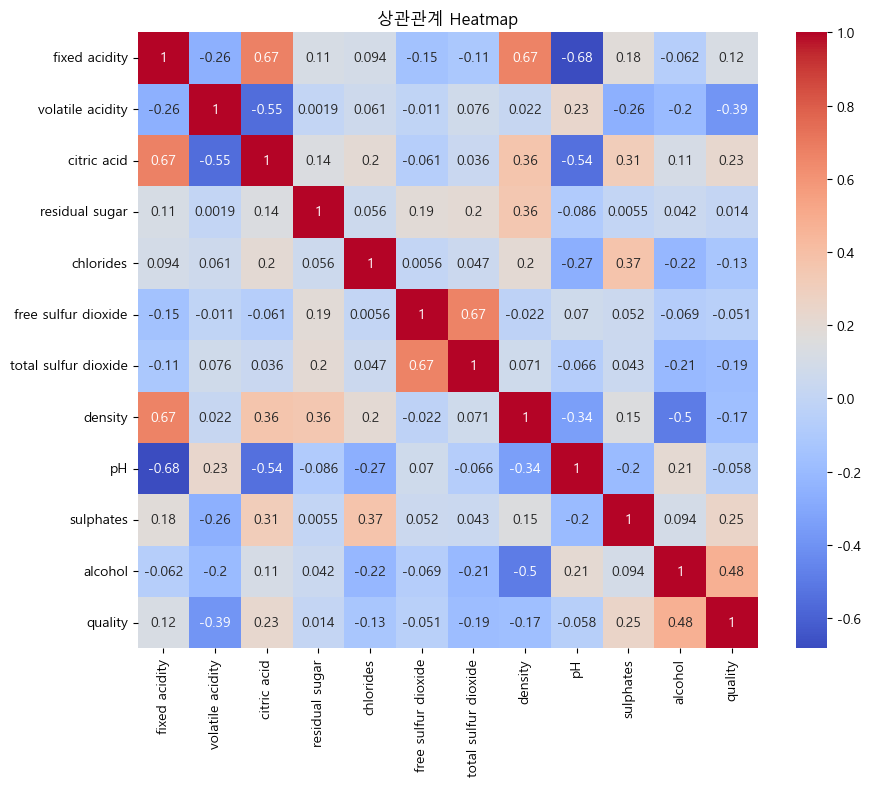

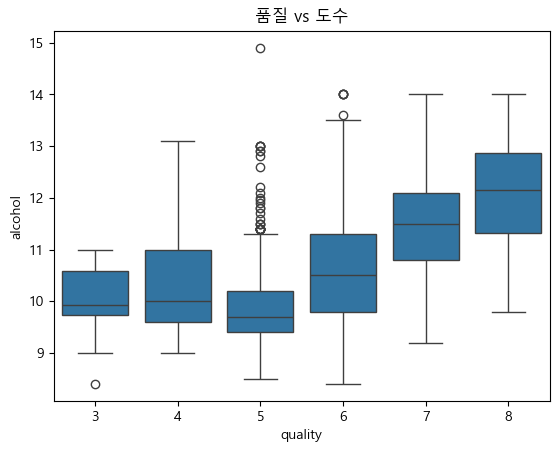

In [5]:
#상관관계 분석
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('상관관계 Heatmap')
plt.show()

sns.boxplot(x='quality', y='alcohol', data=df)
plt.title('품질 vs 도수')
plt.show()

In [6]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Wine Quality Profiling Report", explorative=True)

# output_file='report/wine_report.html'
# profile = ProfileReport(df, title="Wine Quality Report", explorative=True, correlations={"pearson": {"calculate": True}})
# profile.to_file(output_file)
# print("프로파일링 리포트 생성 완료: {output_file}")

In [7]:
# 상관관계가 높은 변수 7개 추출
selected_features = [
    'alcohol',
    'volatile acidity',
    'citric acid',
    'sulphates',
    'density',
    'total sulfur dioxide',
    'fixed acidity'
]

X_selected = df[selected_features]
y = df['quality']

# 모델 학습
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [8]:
# (1) 선형 회귀
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

In [9]:
# (2) 랜덤 포레스트
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [10]:
# (3) XG boost
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred_xgb = xgb_reg.predict(X_test)

rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost 기본 — RMSE: {:.4f}, R2: {:.4f}".format(rmse_xgb, r2_xgb))

XGBoost 기본 — RMSE: 0.6222, R2: 0.4077


In [11]:
#XG Boost 하이퍼파라미터 튜닝
# 튜닝할 파라미터 그리드 설정
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'alpha': [0,1],
    'lambda' : [1, 10]
}

xgb_reg2 = xgb.XGBRegressor(random_state=42)

grid = GridSearchCV(
    estimator=xgb_reg2,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid.best_params_)

best_xgb = grid.best_estimator_

y_pred_best_xgb = best_xgb.predict(X_test)


Fitting 3 folds for each of 972 candidates, totalling 2916 fits
최적 하이퍼파라미터: {'alpha': 0, 'colsample_bytree': 0.8, 'lambda': 1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.8}


In [12]:
#SVR 모델(SVM의 회귀 버전)
from sklearn.svm import SVR

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

svr.fit(X_train_scaled, y_train)
y_pred_svr = svr.predict(X_test_scaled)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR 성능: RMSE={rmse_svr:.3f}, R²={r2_svr:.3f}")

SVR 성능: RMSE=0.725, R²=0.196


In [13]:
#SVR 하이퍼파라미터 튜닝
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.1, 1]
}

svr = SVR()
grid_svr = GridSearchCV(
    estimator=svr,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  # RMSE 기준
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_svr.fit(X_train_scaled, y_train)

print("최적 하이퍼파라미터:", grid_svr.best_params_)

best_svr = grid_svr.best_estimator_
y_pred_best_svr = best_svr.predict(X_test_scaled)

rmse_best_svr = np.sqrt(mean_squared_error(y_test, y_pred_best_svr))
r2_best_svr = r2_score(y_test, y_pred_best_svr)

print(f"SVR 성능: RMSE={rmse_svr:.3f}, R²={r2_svr:.3f}")
print(f"튜닝된 SVR 성능: RMSE={rmse_best_svr:.3f}, R²={r2_best_svr:.3f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
최적 하이퍼파라미터: {'C': 1, 'epsilon': 0.2, 'gamma': 'scale', 'kernel': 'rbf'}
SVR 성능: RMSE=0.725, R²=0.196
튜닝된 SVR 성능: RMSE=0.599, R²=0.452


In [14]:
#LGBM 모델
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgbm.fit(X_train, y_train)

y_pred_lgbm = lgbm.predict(X_test)

rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"RMSE: {rmse_lgbm:.3f}")
print(f"R²: {r2_lgbm:.3f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 1279, number of used features: 7
[LightGBM] [Info] Start training from score 5.623925
RMSE: 0.588
R²: 0.471


In [17]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 기본 모델
lgbm = LGBMRegressor(random_state=42)

# 하이퍼파라미터 후보 (모든 조합 탐색)
param_grid = {
    'num_leaves': [30,40, 50],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.07, 0.1],
    'n_estimators': [300, 600],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0.1, 1],
    'min_child_samples': [20, 40]
}

# GridSearchCV 실행 (모든 조합 탐색)
grid_lgbm = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    verbose=2
)

grid_lgbm.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_lgbm.best_params_)

# 최적 모델로 평가
best_lgbm = grid_lgbm.best_estimator_
y_pred_best_lgbm = best_lgbm.predict(X_test)

rmse_best_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_best_lgbm))
r2_best_lgbm = r2_score(y_test, y_pred_best_lgbm)

print(f"LGBM 성능: RMSE={rmse_lgbm:.3f}, R²={r2_lgbm:.3f}")
print(f"튜닝 후 LGBM 성능: RMSE={rmse_best_lgbm:.3f}, R²={r2_best_lgbm:.3f}")


Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 1279, number of used features: 7
[LightGBM] [Info] Start training from score 5.623925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [38]:
# 모델 성능 평가
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mse_best_xgb= mean_squared_error(y_test, y_pred_best_xgb)
rmse_best_xgb = root_mean_squared_error(y_test, y_pred_best_xgb)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)


print("\n[Linear Regression] 성능 평가")
print(f"RMSE: {rmse_lr:.2f}, MSE: {mse_lr:.2f}, R²: {r2_lr:.2f}")

print("\n[Random Forest] 성능 평가")
print(f"RMSE: {rmse_rf: .2f}, MSE: {mse_rf:.2f}, R²: {r2_rf:.2f}")

print("\n[XG Boost] 성능 평가")
print(f"RMSE: {rmse_best_xgb : .2f}, MSE: {mse_best_xgb: .2f}, R²: {r2_best_xgb: .2f}")


[Linear Regression] 성능 평가
RMSE: 0.63, MSE: 0.40, R²: 0.39

[Random Forest] 성능 평가
RMSE:  0.57, MSE: 0.33, R²: 0.50

[XG Boost] 성능 평가
RMSE:  0.57, MSE:  0.32, R²:  0.51


In [39]:
# 성능 비교 및 최종 모델 선택
print("\n모델 성능 비교 요약:")
print(f"Linear Regression R² = {r2_lr:.4f}")
print(f"Random Forest R² = {r2_rf:.4f}")
print(f"XG Boost R² = {r2_best_xgb:.4f} ")

r2_scores = {
    "Linear Regression": r2_lr,
    "Random Forest": r2_rf,
    "XGBoost": r2_best_xgb
}

best_model_name = max(r2_scores, key=r2_scores.get)

print(f"\n가장 높은 R²를 보인 모델: {best_model_name}")

if best_model_name == "Linear Regression":
    final_model = lr
elif best_model_name == "Random Forest":
    final_model = rf
else:
    final_model = best_xgb

print(f"최종 선택된 모델은 {best_model_name} 입니다.")


모델 성능 비교 요약:
Linear Regression R² = 0.3936
Random Forest R² = 0.5015
XG Boost R² = 0.5112 

가장 높은 R²를 보인 모델: XGBoost
최종 선택된 모델은 XGBoost 입니다.


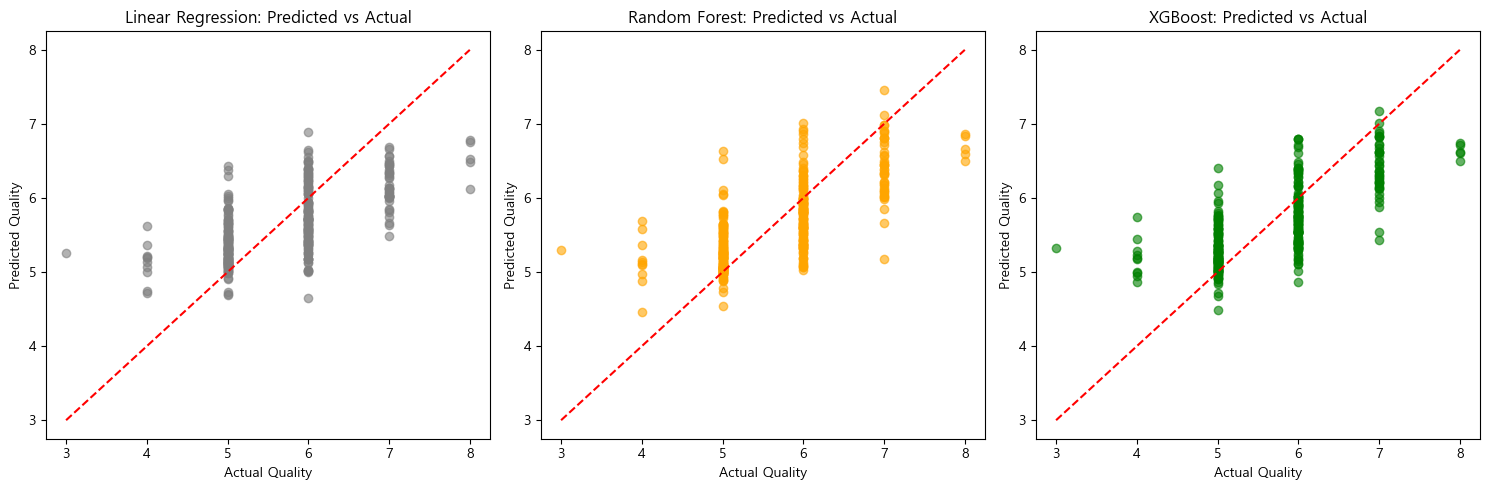

In [40]:
plt.figure(figsize=(15,5))

# (1) 선형 회귀
plt.subplot(1,3,1)
plt.scatter(y_test, y_pred_lr, alpha=0.6, color='gray')
plt.plot([3,8],[3,8],'r--')
plt.title('Linear Regression: Predicted vs Actual')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')

# (2) 랜덤 포레스트
plt.subplot(1,3,2)
plt.scatter(y_test, y_pred_rf, alpha=0.6, color='orange')
plt.plot([3,8],[3,8],'r--')
plt.title('Random Forest: Predicted vs Actual')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')

# (3) XGBoost
plt.subplot(1,3,3)
plt.scatter(y_test, y_pred_best_xgb, alpha=0.6, color='green')
plt.plot([3,8],[3,8],'r--')
plt.title('XGBoost: Predicted vs Actual')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')

plt.tight_layout()
plt.show()


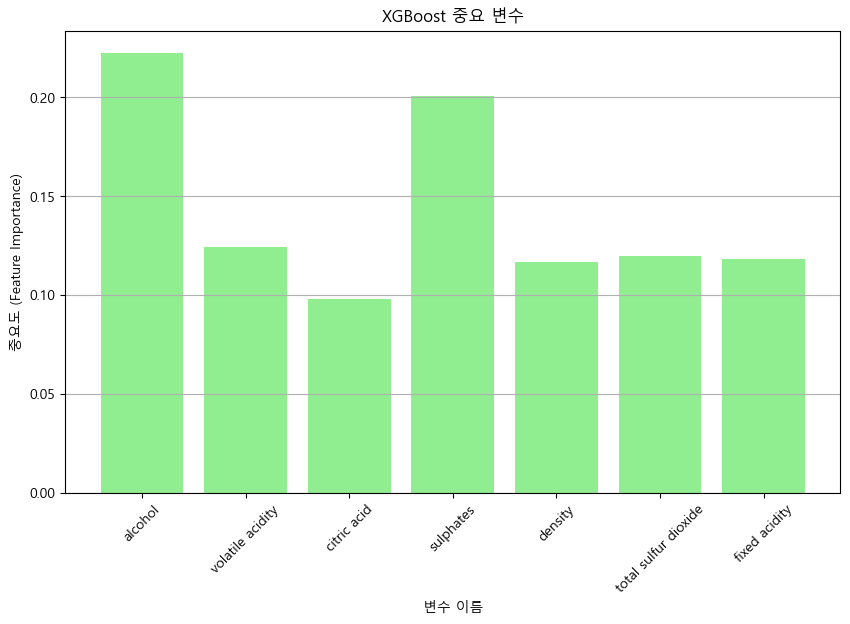

In [41]:
# XGBoost 모델에서 중요도 불러오기
importances = best_xgb.feature_importances_
features = selected_features

# 막대그래프로 시각화
plt.figure(figsize=(10, 6))
plt.bar(features, importances, color='lightgreen')
plt.xlabel("변수 이름")
plt.ylabel("중요도 (Feature Importance)")
plt.title("XGBoost 중요 변수")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


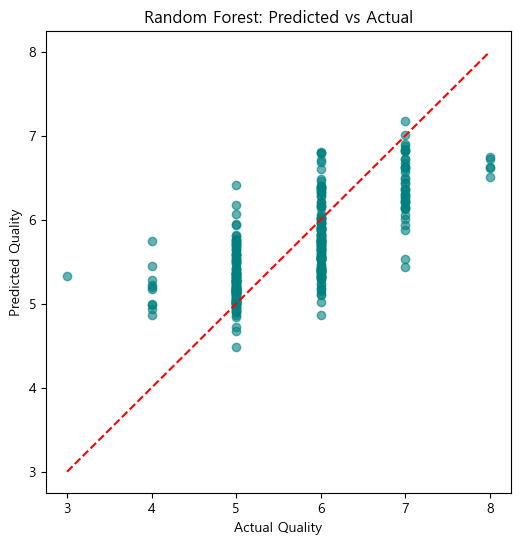

In [20]:
# 10. 예측 vs 실제 비교 시각화
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best_xgb, alpha=0.6, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Random Forest: Predicted vs Actual')
plt.xlabel('Actual Quality')
plt.ylabel('Predicted Quality')
plt.show()

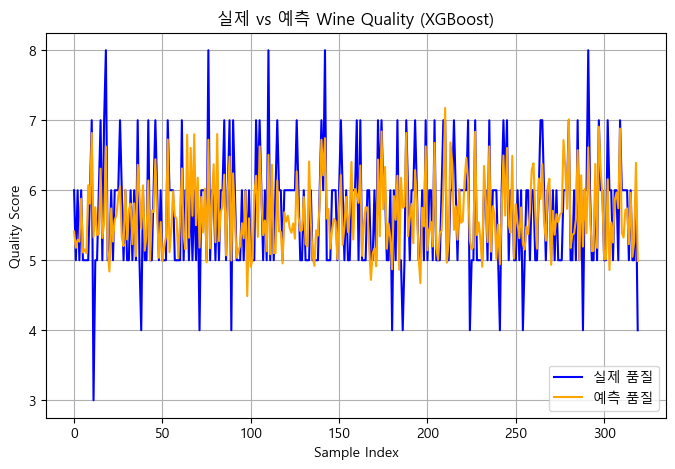

In [42]:
# 10. 예측 vs 실제 비교 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(len(y_test)), y_test.values, label='실제 품질', color='blue')
plt.plot(range(len(y_pred_best_xgb)), y_pred_best_xgb, label='예측 품질', color='orange')
plt.title('실제 vs 예측 Wine Quality (XGBoost)')
plt.xlabel('Sample Index')
plt.ylabel('Quality Score')
plt.legend()
plt.grid(True)
plt.show()


In [43]:
new_wine = pd.DataFrame([{
    'alcohol': 11.2,
    'volatile acidity': 0.45,
    'citric acid': 0.36,
    'sulphates': 0.65,
    'density': 1.0050,
    'total sulfur dioxide': 110,
    'fixed acidity': 7.0
}])

# 예측
pred_quality = final_model.predict(new_wine)[0]
print(f"\n새로운 와인 품질 예측 결과: {pred_quality:.2f}점")



새로운 와인 품질 예측 결과: 5.34점


In [44]:
#최종 모델 저장
joblib.dump(final_model, 'wine_quality_model.pkl')
print("최종 모델 저장 완료: wine_quality_model.pkl")

최종 모델 저장 완료: wine_quality_model.pkl
